# Gradient verification for the 1D pure diffusion case

The goal here is to verify the correctness of the adjoint state method in HYTEC by comparing the results with the demonstrator's which are considered as correct.

In [1]:
from pathlib import Path
import copy
import time
from typing import Dict, Generator
import pyrtid
import pyrtid.forward as dmfwd
import pyrtid.inverse as dminv
import nested_grid_plotter as ngp
import matplotlib.pyplot as plt
from matplotlib.collections import PolyCollection
from matplotlib.animation import HTMLWriter
from IPython.display import HTML
import numpy as np
import os
import pandas as pd
import scipy as sp
import gstools as gs
from pyrtid.utils import (
    NDArrayFloat,
    NDArrayInt,
    gen_random_ensemble,
    node_number_to_indices,
)

gs.config.USE_RUST = True  # Use the rust implementation of gstools

- Type hints definition for numpy arrays

- Check package/software versions

In [2]:
pyrtid.utils.show_versions()

- Create a directory to store the exported figures

In [3]:
ipynb_path = os.path.dirname(os.path.realpath("__file__"))
fig_save_path = Path(ipynb_path, "exported_figures")
fig_save_path.mkdir(parents=True, exist_ok=True)  # make sure that the directory exists

- Define some configurations for the plots

In [4]:
# Some configs for the plots
new_rc_params = {
    "font.family": "sans-serif",
    "font.sans-serif": ["Helvetica", "DejaVu Sans"],
    "font.size": 16,
    "text.usetex": False,
    "savefig.format": "svg",
    "svg.fonttype": "none",  # to store text as text, not as path
    "savefig.facecolor": "w",
    "savefig.edgecolor": "k",
    "savefig.dpi": 300,
    "figure.constrained_layout.use": True,
    "figure.facecolor": "w",
    "axes.facecolor": "w",
}
csfont = {"fontname": "Comic Sans MS"}
hfont = {"fontname": "Helvetica"}
plt.plot()
plt.close()  # required for the plot to update
plt.rcParams.update(new_rc_params)

## Forward problem

- Define a very simple pure diffusion case in 1D.

In [5]:
nx = 20  # number of voxels along the x axis
ny = 1  # number of voxels along the y axis
dx = 10.0  # voxel dimension along the x axis
dy = 10.0  # voxel dimension along the y axis
nt = 200  # number of time steps
dt = 4000.0  # timestep in seconds
c0 = 0  # general initial cocentration
D0 = 1e-3  # general initial diffusion coefficient
w0 = 0.23  # general porosity
wdif = 1.0  # Diffusion
wadv = 0.0  # No avection

- Create an initial "bumped" reference distribution for the diffusion, and a flat one for the initial estimation.

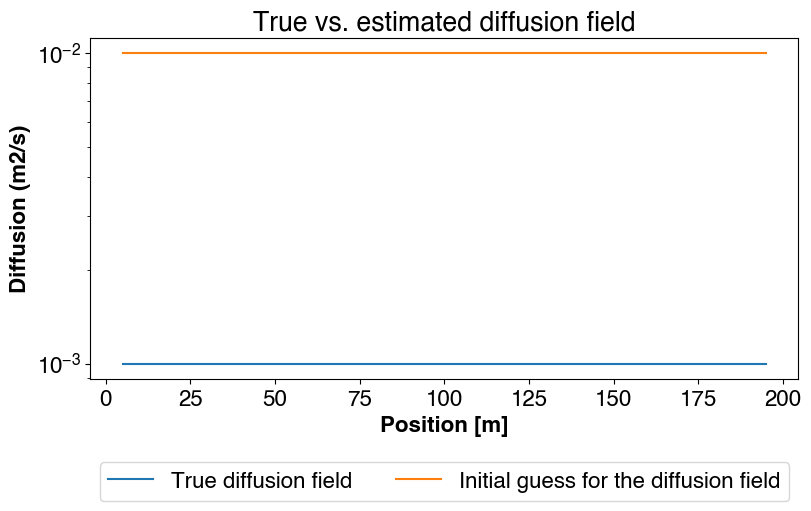

In [6]:
# Exact mineral distribution
diffusion_true: NDArrayFloat = np.ones(nx) * D0

# Estimated diffusion
diffusion_estimated: NDArrayFloat = np.ones(nx) * D0 * 10

plotter = ngp.NestedGridPlotter(fig_params={"figsize": (8, 5)})
plotter.ax_dict["ax1-1"].plot(
    np.arange(nx) * dx + dx / 2, diffusion_true, label="True diffusion field"
)
plotter.ax_dict["ax1-1"].plot(
    np.arange(nx) * dx + dx / 2,
    diffusion_estimated,
    label="Initial guess for the diffusion field",
)
plotter.ax_dict["ax1-1"].set_xlabel("Position [m]", weight="bold")
plotter.ax_dict["ax1-1"].set_ylabel("Diffusion (m2/s)", weight="bold")
plotter.ax_dict["ax1-1"].set_yscale("log")
plotter.ax_dict["ax1-1"].legend(loc="center", bbox_to_anchor=(0.5, -0.3), ncol=2)
plotter.ax_dict["ax1-1"].set_title("True vs. estimated diffusion field")
plotter.fig.set_facecolor("w")

fname = "true_vs_estimated_diffusion_field"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

### Forward problem in demonstrator

- For c_init, need to apply nx+1 in the case of the finite differences for the parameters because of the spatial discretization scheme (finite differences and finite volumes respectively).

In [7]:
# We define a function to easily generate a model.
def create_base_model() -> RTModel:
    return RTModel(nx + 1, ny, dx, dy, nt, dt, c0, D0, w0, wadv=wadv, wdiff=wdif)

NameError: name 'RTModel' is not defined

- Create two models

In [ ]:
model_true = create_base_model()
model_estimate = create_base_model()
# Exact diffusion
model_true.D = diffusion_true.reshape(nx, 1)
# Estimated diffusion
model_estimate.D = diffusion_estimated.reshape(nx, 1)

tmp = np.insert(c_init, -1, values=c_init[-1]).reshape(nx + 1, 1)
model_true.c_init[:, :] = tmp
model_estimate.c_init[:, :] = tmp

- Run the models

In [ ]:
solver_true = RTSolver(model_true)
solver_true.solve()

solver_estimate = RTSolver(model_estimate)
solver_estimate.solve()

### Forward problem definition in HYTEC

- Define a runner

In [ ]:
if runner_type == RunnerType.FRONTAL:
    runner = FrontalHytecRunner(
        hytec_binary_path_or_alias=hytec_binary_path_or_alias,
        mpi_binary_path_or_alias=mpi_binary_path_or_alias,
        nb_cpu=4,
        freq_checks_is_simu_over_sec=5,
    )
elif runner_type == RunnerType.SLURM:
    job_config = JobConfig(
        hytec_binary_path_or_alias=hytec_binary_path_or_alias,
        nb_nodes=1,
        ncpus=4,
        queue="geo-cpu",
        mpi_binary_path_or_alias=mpi_binary_path_or_alias,
        dos2unix_binary_path_or_alias=dos2unix_binary_path_or_alias,
    )
    runner = SlurmHytecRunner(
        job_config=job_config,
        freq_checks_is_simu_over_sec=5,
    )
elif runner_type == RunnerType.QSUB:
    job_config = JobConfig(
        hytec_binary_path_or_alias=hytec_binary_path_or_alias,
        nb_nodes=1,
        ncpus=4,
        queue="Omines_cpu",
        mpi_binary_path_or_alias=mpi_binary_path_or_alias,
        dos2unix_binary_path_or_alias=dos2unix_binary_path_or_alias,
    )
    runner = QsubHytecRunner(
        job_config=job_config,
        freq_checks_is_simu_over_sec=5,
    )
else:
    raise Exception("Could not created runner")

- Create an empty simulation in a non existing folder

In [ ]:
simu_base = HytecSimulation("simu_base", Path.cwd().joinpath("simu_base"))

- Add a TDB file

In [ ]:
simu_base.link_tdb("./../../../../TDB/chess.tdb")  # This is relative to the htc file

- Define the output format

In [ ]:
simu_base.model.add_sub_item(hymd.OutputFormat("vtk"))

- Hydrodynamic model and its parameters definition

In [ ]:
hmodel = hymd.HydrodynamicModel()
hmodel.add_sub_item(hymd.FlowRegime("stationary"))
hmodel.add_sub_item(hymd.Porosity(w0))
hmodel.add_sub_item(hymd.Permeability(0.0, units="m/s"))
hmodel.add_sub_item(hymd.DiffusionCoefficient(D0, units="m2/s"))
hmodel.add_sub_item(hymd.Head(0.0, "m"))
simu_base.model.add_sub_item(hmodel)

- Geochemical unit definition

In [ ]:
chmodel = hymd.GeochemicalModel(hymd.Report("full"), hymd.Redox("disabled"))
# Define a geochem units
base_unit = hymd.GeochemicalUnit("chem_base")
left_unit = hymd.GeochemicalUnit("chem_left")
right_unit = hymd.GeochemicalUnit("chem_right")
species = "T"
# Set concentrations
base_unit.add_sub_item(hymd.Concentration(species, 1.0, units="molal"))
left_unit.add_sub_item(hymd.Concentration(species, 3.0, units="molal"))
right_unit.add_sub_item(hymd.Concentration(species, 2.0, units="molal"))

# define tracer
chmodel.add_sub_item(hymd.Define("basis", species))

# exclude
chmodel.add_sub_item(hymd.Exclude(("minerals", "colloids", "gases")))

# Add the units to the geochemical model
chmodel.add_sub_item(base_unit)
chmodel.add_sub_item(left_unit)
chmodel.add_sub_item(right_unit)

# Add to the main model
simu_base.model.add_sub_item(chmodel)

- Geometry definition

In [ ]:
gmodel = hymd.GeometryModel(
    hymd.GridRegime("rectangle"), hymd.Domain(f"{nx*dx},{nx} {ny*dy},{ny}")
)
zone_domain = hymd.Zone(
    "domain", hymd.Geometry("domain"), hymd.Geochemistry(base_unit.name)
)
gmodel.add_sub_item(zone_domain)
simu_base.model.add_sub_item(gmodel)

- Boundary model definition

In [ ]:
# Boundary conditions
flc = hymd.FlowCondition("constant-head at 0 m")
lcc = hymd.TransportCondition(f"constant-conc using {left_unit.name}")
rcc = hymd.TransportCondition(f"constant-conc using {right_unit.name}")
bmodel = hymd.BoundaryModel(
    hymd.Boundary(
        "border_left", hymd.Coordinates(f"0,0, 0,{ny*dy}", units="m"), lcc, flc
    ),
    hymd.Boundary(
        "border_right",
        hymd.Coordinates(f"{nx*dx},{ny*dy}, {nx*dx},0", units="m"),
        rcc,
        flc,
    ),
)
simu_base.model.add_sub_item(bmodel)

- Time discretization

In [ ]:
tmodel = hymd.TimeDiscretizationModel(
    hymd.Duration(nt * dt, units="s"),
    hymd.TimeStep(
        hymd.Variable(
            hymd.StartValue(dt, "s"), hymd.Maximum(dt, "s"), hymd.CourantFactor(20.0)
        ),
    ),
)
simu_base.model.add_sub_item(tmodel)

- Sampling definition

In [ ]:
smodel = hymd.SamplingModel(
    hymd.GridSampling(nt),
    hymd.Select("time", units="s"),
    hymd.Select("node-number"),
    hymd.Select("diffusion", units="m2/s"),
    hymd.Select(species, units="mol/kg"),
)
simu_base.model.add_sub_item(smodel)

- Create two models from this base simulation

In [ ]:
simu_reference = copy.deepcopy(simu_base)
simu_reference.update_root_and_name(
    new_root="simu_reference", new_name="simu_reference"
)
simu_estimate = copy.deepcopy(simu_base)
simu_estimate.update_root_and_name(new_root="simu_estimate", new_name="simu_estimate")

- Add the diffusion fields to the simulations

In [ ]:
index: NDArrayFloat = np.arange(nx)

# True
data_true = pd.DataFrame(
    data={
        "node-number": index,
        # x and y are cell centers
        "x": (index % nx) * dx + dx / 2,
        "porosity": 1.0,
        "diffusion": diffusion_true.ravel(),
    },  # need to flatten the parameter
    index=index,
)
simu_reference.add_param_file_data(ParameterFiles.HYDRO, data_true)

# Estimated
data_estimated = pd.DataFrame(
    data={
        "node-number": index,
        # x and y are cell centers
        "x": (index % nx) * dx + dx / 2,
        "porosity": 1.0,
        "diffusion": diffusion_estimated.ravel(),
    },  # need to flatten the parameter
    index=index,
)
simu_estimate.add_param_file_data(ParameterFiles.HYDRO, data_estimated)

- Checking the hydro parameters have been correctly set-up

In [ ]:
simu_reference.handlers.hydro.data

In [ ]:
simu_estimate.handlers.hydro.data

In [ ]:
simu_reference.write_input_files()
simu_estimate.write_input_files()
runner.run(simu_reference)
runner.run(simu_estimate)

### Comparison between hytec and the demonstrator for the forward problem

- Reading the results for the reference diffusion simulation

In [ ]:
simu_reference.read_hytec_results()
simu_reference.handlers.results.grid_res_columns

In [ ]:
fwd_conc_true_hytec = simu_reference.handlers.results.extract_field_from_grid_res(
    field="T [mol/kg]", nx=nx
)
diff_true_hytec = simu_reference.handlers.results.extract_field_from_grid_res(
    field="diffusion [m2/s]", nx=nx
)
# Getting sample time. The unit is the same than the one defined for the simulation duration in the htc
flux_sample_times = simu_reference.handlers.results.get_sample_times_from_grid_res()

- Reading the results for the estimated diffusion simulation

In [ ]:
simu_estimate.read_hytec_results()
simu_estimate.handlers.results.grid_res_columns

In [ ]:
# Get the results on a 3D grid with the last dimension as time step
fwd_conc_estimate_hytec = simu_estimate.handlers.results.extract_field_from_grid_res(
    field="T [mol/kg]", nx=nx
)
diff_estimate_hytec = simu_estimate.handlers.results.extract_field_from_grid_res(
    field="diffusion [m2/s]", nx=nx
)

- Some fun plots, not very informative though...

In [ ]:
# Let's create a 3D plotter to visualize the results
plotter_3d = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (13, 6)},
    subfigs_params={"ncols": 4},
    subplots_mosaic_params={
        "reference demonstrator": {
            "mosaic": [["ax1-1"]],
            "subplot_kw": {"projection": "3d"},
        },
        "estimate demonstrator": {
            "mosaic": [["ax1-2"]],
            "subplot_kw": {"projection": "3d"},
        },
        "reference hytec": {"mosaic": [["ax1-3"]], "subplot_kw": {"projection": "3d"}},
        "estimate hytec": {"mosaic": [["ax1-4"]], "subplot_kw": {"projection": "3d"}},
    },
)
plotter_3d.fig.patch.set_facecolor("w")

data: NDArrayFloat = solver_true.model.fwd_conc[:, 0, :]
X, Y = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]))
ax = plotter_3d.ax_dict["ax1-1"]
ax.plot_surface(X, Y, data.T, cmap=plt.cm.coolwarm)
# Inverse the time axis to get a better display
ax.set_ylim(reversed(ax.get_ylim()))
plotter_3d.subfigs["reference demonstrator"].suptitle("True demonstrator")
ax.set_xlabel("Nodes #")
ax.set_ylabel("Timestep #")
ax.set_zlabel("Tracer concentration [molal]")

data: NDArrayFloat = solver_estimate.model.fwd_conc[:, 0, :]
ax = plotter_3d.ax_dict["ax1-2"]
ax.plot_surface(X, Y, data.T, cmap=plt.cm.coolwarm, alpha=0.9)
# Inverse the time axis to get a better display
ax.set_ylim(reversed(ax.get_ylim()))
plotter_3d.subfigs["estimate demonstrator"].suptitle("Estimate demonstrator")

data: NDArrayFloat = fwd_conc_true_hytec[:, 0, 0, :]
X, Y = np.meshgrid(np.arange(data.shape[0]), np.arange(data.shape[1]))
ax = plotter_3d.ax_dict["ax1-3"]
ax.plot_surface(X, Y, data.T, cmap=plt.cm.coolwarm, alpha=0.9)
# Inverse the time axis to get a better display
ax.set_ylim(reversed(ax.get_ylim()))
plotter_3d.subfigs["reference hytec"].suptitle("True Hytec")

data: NDArrayFloat = fwd_conc_estimate_hytec[:, 0, 0, :]
ax = plotter_3d.ax_dict["ax1-4"]
ax.plot_surface(X, Y, data.T, cmap=plt.cm.coolwarm, alpha=0.9)
# Inverse the time axis to get a better display
ax.set_ylim(reversed(ax.get_ylim()))
plotter_3d.subfigs["estimate hytec"].suptitle("Estimate Hytec")

- Top view

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 12)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"], ["ax4-1"]],
            sharey=True,
            sharex=True,
        )
    },
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "True model demonstrator": solver_true.model.fwd_conc[:, 0, :].T,
        "A priori (estimate) model demonstartor": solver_estimate.model.fwd_conc[
            :, 0, :
        ].T,
        "True model hytec": fwd_conc_true_hytec[:, 0, 0, :].T,
        "A priori (estimate) model hytec": fwd_conc_estimate_hytec[:, 0, 0, :].T,
    },
)

fname = "tracer_concentration_true_vs_estimate_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Consider three observation locations

In [ ]:
observation_locations = [6, 10, 15]

- Let's now consider that we have some observation wells. We can plot what the observation well would sample in both cases and see the difference. Let's place three wells at positions `65m`, `105m` and `155m` (at the center of the nodes).

In [ ]:
from typing import List, Tuple


def polygon_under_graph(x: np.ndarray, y: np.ndarray) -> List[Tuple[float, float]]:
    """
    Construct the vertex list which defines the polygon filling the space under
    the (x, y) line graph. This assumes x is in ascending order.
    """
    return [(x[0], 0.0), *zip(x, y), (x[-1], 0.0)]


y_dim = solver_true.model.fwd_conc.shape[2]
z_max = solver_true.model.fwd_conc.max()
y = np.arange(y_dim)
z = np.ones(y_dim) * z_max

# verts[i] is a list of (x, y) pairs defining polygon i.
verts = [polygon_under_graph(y, z)] * len(observation_locations)

poly1 = PolyCollection(verts, facecolors="g", alpha=0.2, zorder=10)
poly2 = PolyCollection(verts, facecolors="g", alpha=0.2, zorder=10)
poly3 = PolyCollection(verts, facecolors="g", alpha=0.2, zorder=10)
poly4 = PolyCollection(verts, facecolors="g", alpha=0.2, zorder=10)

plotter_3d.ax_dict["ax1-1"].add_collection3d(poly1, zs=observation_locations, zdir="x")
plotter_3d.ax_dict["ax1-2"].add_collection3d(poly2, zs=observation_locations, zdir="x")
plotter_3d.ax_dict["ax1-3"].add_collection3d(poly3, zs=observation_locations, zdir="x")
plotter_3d.ax_dict["ax1-4"].add_collection3d(poly4, zs=observation_locations, zdir="x")

for node_id in observation_locations:
    x = [node_id] * 2
    y = [solver_true.model.fwd_conc.shape[2]] * 2
    z = (0.0, z_max)

    plotter_3d.ax_dict["ax1-1"].plot(
        x, y, z, label="parametric curve", linewidth=3.0, zorder=10, c="g"
    )
    plotter_3d.ax_dict["ax1-2"].plot(
        x, y, z, label="parametric curve", linewidth=3.0, zorder=10, c="g"
    )
    plotter_3d.ax_dict["ax1-3"].plot(
        x, y, z, label="parametric curve", linewidth=3.0, zorder=10, c="g"
    )
    plotter_3d.ax_dict["ax1-4"].plot(
        x, y, z, label="parametric curve", linewidth=3.0, zorder=10, c="g"
    )

fname = "tracer_concentration_true_vs_estimate_3D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 8)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"]], sharey=False, sharex=True
        )
    },
)

for i, node_id in enumerate(observation_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * model_true.dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        (np.arange(nx) + 0.5) * dx,
        solver_true.model.fwd_conc[node_id, 0, :],
        label="Reference demonstrator",
        c="b",
    )
    ax.plot(
        (np.arange(nx) + 0.5) * dx,
        solver_estimate.model.fwd_conc[node_id, 0, :],
        label="A priori demonstrator",
        c="r",
    )
    ax.plot(fwd_conc_true_hytec[node_id, 0, 0, :], label="Reference Hytec", c="g")
    ax.plot(fwd_conc_estimate_hytec[node_id, 0, 0, :], label="A priori Hytec", c="k")

plotter.fig.suptitle("Tracer at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "tracer_concentration_true_vs_estimate_at_obs_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

In [ ]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (12, 5)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1", "ax1-2"]], sharey=True, sharex=True)
    },
)

# Static plot
for ax_name in ["ax1-1", "ax1-2"]:
    plotter.get_axis(ax_name).plot(1.0, c="red", label="Initial")

# Animated plot
nb_frames = 30

plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "True": {"y": fwd_conc_true_hytec[:, 0, 0, :], "kwargs": {"c": "blue"}},
        "Estimated": {
            "y": fwd_conc_estimate_hytec[:, 0, 0, :],
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
    title="HYTEC conc",
    xlabel="Node #",
    ylabel="[mol/l]",
)

plotter.animated_multi_plot(
    ax_name="ax1-2",
    data={
        "True": {"y": solver_true.model.fwd_conc[:, 0, :], "kwargs": {"c": "blue"}},
        "Estimated": {
            "y": solver_estimate.model.fwd_conc[:, 0, :],
            "kwargs": {"c": "green", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
    title="Demonstrator conc",
    xlabel="Node #",
)


# plot the time
def get_time() -> Generator[str, None, None]:
    ts_btw_frames = int(fwd_conc_estimate_hytec.shape[-1] / nb_frames)
    for frame in range(nb_frames):
        yield f"time = {flux_sample_times[ts_btw_frames * frame] / 3600:.3f} h"


for ax_name in ["ax1-1", "ax1-2"]:
    # Add some vertical lines to indicate the well
    for well_pos in observation_locations:
        # handle = plotter.ax_dict["ax1-1"].axvline(
        #     x=well_pos, linestyle="--", line
        # )
        # plotter.add_extra_legend_item("ax1-1", handle, "hm_end_time")
        plotter.get_axis(ax_name).plot(
            well_pos,
            0.0002,
            label="obs wells",
            marker="^",
            markersize=10,
            c="r",
            linestyle="none",
        )

    plotter.plot_animated_text(
        ax=plotter.get_axis(ax_name),
        x=0.83,
        y=0.92,
        s=list(get_time()),
        horizontalalignment="center",
        verticalalignment="center",
        transform=plotter.get_axis(ax_name).transAxes,
        fontsize=14,
        fontweight="bold",
    )

    plotter.add_axis_legend(ax_name)

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("true_vs_estimate_conc_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(fname_html, writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

## Inversion

- Create a function to add some noise to the observations

In [ ]:
noise_std: float = 2e-4  # This is an absolute value
rng = np.random.default_rng(2021)


def make_noisy(x: NDArrayFloat) -> NDArrayFloat:
    """Return the input with some added white noise.

    Note
    ----
    The parameters are hardcoded to be consistent in the notebook.
    Change the function directly.
    """
    mean_noise = 0.0  # mean
    return x + rng.normal(mean_noise, noise_std, x.shape)

### Demonstrator


In [ ]:
param = PyrtidAdjustableParameter(
    name="diffusion", lbounds=2e-5, ubounds=5e-3, preconditioner=dminv.LogTransform()
)

from typing import Dict  # Just for linting

observables: Dict[int, PyrtidObservable] = {}
for node_id in observation_locations:
    vals = make_noisy(solver_true.model.fwd_conc[node_id, 0, :])
    timesteps = np.arange(vals.shape[0])

    observables[node_id] = PyrtidObservable(
        state_variable="tracer",
        location=(slice(node_id, node_id + 1, 1), slice(None)),
        timesteps=timesteps,
        values=vals,
        uncertainties=noise_std,
    )

# Create an executor
executor = ScipyInversionExecutor(
    model_estimate,
    parameters_to_adjust=[param],
    observables=list(observables.values()),
    solver_config=ScipySolverConfig(),
)

# Compute the gradient both by finite difference and adjoint method
is_grad_ok = executor.is_gradient_correct(
    param,
    list(observables.values()),
)
print("Is the gradient correct: ", is_grad_ok)

### HYTEC

In [ ]:
# 1) Copy the base simulation
simu_inverse = copy.deepcopy(simu_estimate)
simu_inverse.update_root_and_name(new_root="simu_inverse", new_name="simu_inverse")

# 2) Add the observation wells
for count, ix in enumerate(observation_locations):
    x = (ix + 0.5) * model_true.dx
    name = f"well_{ix}"
    zone = hymd.Zone(name)
    zone.add_sub_item(
        hymd.Geometry(
            f"rectangle {x},{model_true.dx/2}, {model_true.dx/2},{model_true.dy/2}",
            units="m",
        )
    )
    zone.add_sub_item(hymd.Geochemistry(base_unit.name))

    simu_inverse.model.get_sub_model(hymd.GeometryModel).add_sub_item(zone)
    vals = make_noisy(fwd_conc_true_hytec[ix, 0, 0, :])

    # Add the observables for the area
    obs = Observable(
        zone_name=zone.name,
        state_variable=species,
        units="mol/kg",
        timesteps=flux_sample_times,
        time_units="s",
        obs_type=ObservationType.GRID,
        values=vals,
        uncertainties=np.ones(vals.size) * noise_std,
        node_numbers=np.ones(vals.size) * ix,
    )
    simu_inverse.register_observable(
        zone.name, obs, obs_file_path=f"observables/{zone.name}_{species}_o.dat"
    )

# 3) Update the htc file with some options
inv_model = hymd.InverseModel(
    hymd.OptimizationStatus("enabled"),
    hymd.OptimizationSolverConfig(
        "lbfgsb", hymd.AdjointState("enabled"), hymd.FdGradientCheck("initial")
    ),
    hymd.AdjustedParameterConfig(
        "diffusion",
        hymd.Lbound(1e-7, units="mol/kg"),
        hymd.Ubound(1e-2, units="mol/kg"),
        hymd.Preconditioner("logarithmic"),
    ),
)

simu_inverse.model.add_sub_item(inv_model)

# number of samples on the adjoint variables
simu_inverse.model.get_sub_model(hymd.SamplingModel).add_sub_item(
    hymd.AdjointGridSampling(nt)
)

# 4)Write the input files
simu_inverse.write_input_files()

runner.run(simu_inverse)

# 7) Read results
simu_inverse.read_hytec_results()  # This fails if not results have been written

- Extract the adjoint variables computed for the first gradient

In [ ]:
print(f"columns = {simu_inverse.handlers.results.optim_res.adjoint_var_columns}")

In [ ]:
adj_conc_hytec = simu_inverse.handlers.results.extract_field_from_adj_var_res(
    field="adjoint-variable{T} [m]", nx=nx
)
adj_conc_hytec.shape

In [ ]:
plotter = ngp.AnimatedPlotter(
    fig_params={"constrained_layout": True, "figsize": (6, 5)},
)

# Static plot
plotter.get_axis("ax1-1").plot([0.0] * nx, c="red", label="Initial")


# Animated plot
nb_frames = 30

plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "Adj": {
            "x": (np.arange(nx) + 0.5) * dx,
            "y": adj_conc_hytec[:, 0, 0, ::-1],
            "kwargs": {"c": "blue"},
        },
    },
    nb_frames=nb_frames,
    title="Adjoint conentrations",
    xlabel="X [m]",
    ylabel="[mol/l]",
)


# plot the time
def get_time() -> Generator[str, None, None]:
    ts_btw_frames = int(fwd_conc_estimate_hytec.shape[-1] / nb_frames)
    for frame in reversed(range(nb_frames)):
        yield f"time = {flux_sample_times[ts_btw_frames * frame] / 3600:.1f} h"


plotter.plot_animated_text(
    ax=plotter.ax_dict["ax1-1"],
    x=0.2,
    y=0.9,
    s=list(get_time()),
    horizontalalignment="center",
    verticalalignment="center",
    transform=plotter.ax_dict["ax1-1"].transAxes,
    fontsize=14,
    fontweight="bold",
)

for ax_name in ["ax1-1"]:
    # Add some vertical lines to indicate the well
    for well_pos in observation_locations:
        # handle = plotter.ax_dict["ax1-1"].axvline(
        #     x=well_pos, linestyle="--", line
        # )
        # plotter.add_extra_legend_item("ax1-1", handle, "hm_end_time")
        plotter.ax_dict[ax_name].plot(
            (well_pos + 1) * dx - dx / 2,
            0.0002,
            label="obs wells",
            marker="^",
            markersize=10,
            c="r",
            linestyle="none",
        )

    plotter.add_axis_legend(ax_name)

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("adjconc_animation.html")
writer = HTMLWriter(fps=5, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(fname_html, writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

### Results comparison

The adjoint concentrations should be quite the same both in shape and intensity.

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (10, 6)},
    subplots_mosaic_params={
        "fig0": dict(mosaic=[["ax1-1"], ["ax2-1"]], sharey=True, sharex=True)
    },
)

ngp.multi_imshow(
    axes=list(plotter.ax_dict.values()),
    fig=plotter.fig,
    data={
        "Adj. var demonstrator": executor.rt_solver.inverse_model.adj_conc[:, 0, :].T,
        "Adj. var HYTEC": adj_conc_hytec[:, 0, 0, :].T,
    },
)

fname = "adjoint_concentrations_dem_vs_hytec_map"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

Let's check the adjoint variables at the three observation wells. Note that only the right one has been used as an adjoint source (node_id == 15).

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 8)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"]], sharey=False, sharex=True
        )
    },
)

for i, node_id in enumerate(observation_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * model_true.dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        executor.rt_solver.inverse_model.adj_conc[node_id, 0, :],
        label="Adj. var. Demonstrator",
        c="g",
    )
    ax.plot(adj_conc_hytec[node_id, 0, 0, :], label="Adj. var. HYTEC", c="r")

plotter.fig.suptitle("Tracer adjoint variable", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "adjoint_concentrations_dem_vs_hytec_1D"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

- Get the gradients by the adjoint method and finite differences

Finally, plot the gradients comparison.

In [ ]:
# Get the HYTEC  Adj gradient
hytec_fd_gradient = simu_inverse.handlers.results.optim_res.fd_gradients[0]
hytec_adjoint_gradient = simu_inverse.handlers.results.optim_res.adjoint_gradients[0]

In [ ]:
param.grad_adj_history[0]

In [ ]:
# Here comes the python code
plotter = ngp.NestedGridPlotter()
ax = plotter.get_axis("ax1-1")
ax.plot(param.grad_adj_history[0], label="Adj. Demonstrator", c="b")
ax.plot(param.grad_fd_history[0], label="FD Demonstrator", c="r", linestyle="--")
ax.plot(hytec_adjoint_gradient["value"], label="Adj. HYTEC", c="g", linestyle="-")
ax.plot(hytec_fd_gradient["value"], label="FD HYTEC", c="k", linestyle="--")


plotter.fig.suptitle("Gradient at first iteration")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.1)

fname = "gradient_dem_vs_hytec_adj_vs_df_1d_diffusion"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)

# Full optimization

In [ ]:
# 1) Copy the base simulation
simu_inverse2 = copy.deepcopy(simu_inverse)
simu_inverse2.update_root_and_name(
    new_root="simu_inverse_lbfgsb", new_name="simu_inverse_lbfgsb"
)

# 2) Update the htc file with some options
inv_model = hymd.InverseModel(
    hymd.OptimizationStatus("enabled"),
    hymd.OptimizationSolverConfig(
        "lbfgsb",
        hymd.AdjointState("enabled"),
        hymd.FdGradientCheck("disabled"),
        hymd.MaxNumberFwdModelEval(30),
        hymd.MaxNumberIterations(20),
        hymd.MaxNumberGradientEval(30),
        hymd.ObjFunThreshold(1e-1),
        hymd.GradHistorySize(5),
    ),
    hymd.AdjustedParameterConfig(
        "diffusion",
        hymd.Lbound(1e-7, units="mol/kg"),
        hymd.Ubound(1e-2, units="mol/kg"),
        hymd.Preconditioner("logarithmic"),
    ),
)
simu_inverse2.model.add_sub_item(inv_model, is_verbose=False)

# 4)Write the input files
simu_inverse2.write_input_files()
runner.run(simu_inverse2)

# 5) Read the results
simu_inverse2.read_hytec_results()

In [ ]:
# 5) Read the results
simu_inverse2.read_hytec_results()

- Get the concentrations

In [ ]:
# Get the results on a 3D grid with the last dimension as time step
fwd_conc_inversed_hytec = simu_inverse2.handlers.results.extract_field_from_grid_res(
    field="T [mol/kg]", nx=nx
)

- Get the gradients 

In [ ]:
print(simu_inverse2.handlers.results.optim_res.adjoint_gradients[0].columns)

adjoint_gradients = simu_inverse2.handlers.results.get_adjoint_gradient(
    "diffusion", nx=nx, ny=ny
)
fd_gradients = simu_inverse2.handlers.results.get_fd_gradient("diffusion", nx=nx, ny=ny)
adjusted_diffusion = simu_inverse2.handlers.results.get_adjusted_parameter_field(
    "diffusion", nx=nx, ny=ny
)
obj_funs = simu_inverse2.handlers.results.optim_res.obj_funs

- Align gradients and objective functions: Because of the construction in HYTEC, unless I am mistaken, the objective function and fitted parameter vectors match exactly. On the other hand, there is an uncontrolled mismatch with the gradients due to the solver which, depending on its needs, may have to apply several objective functions in a row or several gradients. This function makes sure that the two match for a good rendering of the animations.

In [ ]:
grad_index = 0
grad_obj_funs = (
    simu_inverse2.handlers.results.optim_res.obj_funs_matching_adjoint_gradients
)

# Example: [3, 4, 4, 5, 7, 8, 8, 9]

aligned_adjoint_gradients = np.empty(
    (*adjoint_gradients[:, :, :, 0].shape, obj_funs.size)
)
aligned_adjoint_gradients.fill(np.nan)

previous_index: int = -1
for i, index in enumerate(grad_obj_funs):
    if index == previous_index:
        continue
    if index > obj_funs.size:
        continue
    previous_index = index
    aligned_adjoint_gradients[:, :, :, index - 1] = adjoint_gradients[:, :, :, i]

# Fill the first missing gradients
# Gradients 1 and 2 in the example
for i2 in range(grad_obj_funs[0] - 1):
    aligned_adjoint_gradients[:, :, :, i2] = aligned_adjoint_gradients[
        :, :, :, grad_obj_funs[0]
    ]

- Get the observations and the predictions vector to plot it against each others

In [ ]:
obs_vector = simu_inverse2.get_observation_vector()
pred_vector = simu_inverse2.get_results_matching_obs_vector(
    simu_inverse2.get_observables()
)

- Plot the main results

In [ ]:
plotter = ngp.AnimatedPlotter(
    fig_params={"figsize": (10.0, 8.0)}, subfigs_params={"nrows": 2, "ncols": 2}
)

# 1 frame per solver iteration
nb_frames: int = obj_funs.shape[0]

# 1) Gradient evolution
plotter.get_axis("ax1-1").plot(
    aligned_adjoint_gradients[:, 0, 0, 0], label="Initial", c="b"
)
plotter.get_axis("ax1-1").set_title("Gradient", fontweight="bold")
# xlabel="Node #"

plotter.animated_multi_plot(
    ax_name="ax1-1",
    data={
        "ADJ": {"y": aligned_adjoint_gradients[:, 0, 0, :], "kwargs": {"c": "g"}},
    },
    nb_frames=nb_frames,
)

plotter.ax_dict["ax1-1"].legend()


# 2) Parameter evolution
plotter.get_axis("ax1-2").plot(model_true.D, c="b", label="Reference")
plotter.get_axis("ax1-2").plot(
    adjusted_diffusion[:, 0, 0, 0], c="orange", label="Initial"
)
plotter.animated_multi_plot(
    ax_name="ax1-2",
    data={
        "Inverted": {
            "y": adjusted_diffusion[:, 0, 0, :],
            "kwargs": {"c": "r", "linestyle": "--"},
        },
    },
    nb_frames=nb_frames,
)
plotter.get_axis("ax1-2").set_title("Diffusivity field", fontweight="bold")
plotter.get_axis("ax1-2").set_xlabel("Node #")
plotter.get_axis("ax1-2").set_ylabel("[m2/s]")
plotter.ax_dict["ax1-2"].legend()
plotter.ax_dict["ax1-2"].set_yscale("log")

# 3) Objective function
vals = obj_funs
obj_fun_vals = np.full((len(vals), nb_frames), fill_value=np.nan)
for i in range(len(vals)):
    obj_fun_vals[: i + 1, i] = vals[: i + 1]

plotter.animated_multi_plot(
    ax_name="ax2-1",
    data={
        "Obj fun": {"y": obj_fun_vals, "kwargs": {"c": "r", "linestyle": "--"}},
    },
    nb_frames=nb_frames,
    title="Objective function",
    xlabel="Iteration #",
)
plotter.ax_dict["ax2-1"].set_yscale("log")

# 4) Observation vs predicted values
plot_observed_vs_simulated(
    plotter.ax_dict["ax2-2"],
    obs_vector=simu_inverse2.get_observation_vector() * 1000,
    pred_vector=simu_inverse2.get_results_matching_obs_vector(
        simu_inverse2.get_observables()
    )
    * 1000,
    pred_vector_initial=simu_estimate.get_results_matching_obs_vector(
        simu_inverse2.get_observables()
    )
    * 1000,
    units="$mmol.l^{-1}$",
)

plotter.close()
plotter.animate(nb_frames=nb_frames)
# Save the animation locally on the computer
fname_html = fig_save_path.joinpath("m_j_g_animation.html")
writer = HTMLWriter(fps=2, embed_frames=True)
writer.frame_format = "svg"  # Ensure svg format
plotter.animation.save(fname_html, writer=writer)

# Extract the svg from the html file (for animation in Latex)
ngp.extract_frames_from_embedded_html_animation(fname_html)

# Display the animation
HTML(fname_html.read_text())

- Plot the concentrations

In [ ]:
plotter = ngp.NestedGridPlotter(
    fig_params={"constrained_layout": True, "figsize": (8, 8)},
    subplots_mosaic_params={
        "fig0": dict(
            mosaic=[["ax1-1"], ["ax2-1"], ["ax3-1"]], sharey=False, sharex=True
        )
    },
)

for i, node_id in enumerate(observation_locations):
    ax = plotter.get_axis(f"ax{i + 1}-1")
    x = (node_id + 0.5) * model_true.dx
    obs_well_name = f"obs. well @ node #{node_id} (x={x}m)"

    ax.set_title(obs_well_name)
    ax.plot(
        make_noisy(fwd_conc_true_hytec[node_id, 0, 0, :]),
        label="Reference HYTEC (noisy)",
        c="g",
        linestyle="none",
        marker=".",
        alpha=0.5,
    )
    ax.plot(fwd_conc_estimate_hytec[node_id, 0, 0, :], label="A priori HYTEC", c="r")
    ax.plot(
        fwd_conc_inversed_hytec[node_id, 0, 0, :], label="Post inversion HYTEC", c="b"
    )

plotter.fig.suptitle("Tracer at obs wells", fontweight="bold")
plotter.add_fig_legend(ncol=2, bbox_y_shift=-0.02)

fname = "tracer_concentrations_after_inversion"
for format in ["png", "pdf"]:
    plotter.savefig((fig_save_path.joinpath(f"{fname}.{format}")), format=format)